In [1]:
import pandas as pd
import re
import konlpy
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import numpy as np
from tqdm import tqdm
import urllib.request

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-2, 2))

In [64]:
# 데이터 불러오기
df = pd.read_table('민주당.csv')
df = df.rename(columns={"제목,본문,댓글": "sentence"})
df

,sentence
0,"모노리서치 김경수 차기 경남지사 지지율 위,재판만 잘 되면 재선 충분히 가능,도정..."
1,"신동근 우리 민주당이 언제부터 부자들을 위한 정당이었지,,민주당 내부에 카르텔 벌레..."
2,"윾승민 아직도 조국 찬양하는 민주당 한심하다,네 다음 진짜로 청탁주려다 걸린 찐따,..."
3,"르포 준석이가 당대표 되나요 노원 상계동 말 들어보니,초선도 아닌 선 이준석각종 ..."
4,"김남국 황,이런 미친 새가,저쪽이랑 친목질이라니 그냥 네 감사합니다나 선거 건승하세..."
5,"이준석 민주당이 윤석열 처가로 공격할 때 대응법 있다,일단 윤석열이 우리 당에 와야..."
6,"조국의 시간 차트 올킬이네 ,하 이런데도 손절해야 한다던 그놈의 여론 대변자들 오히..."
7,"조국 전 장관 회고록에 초선족 반응,,자서전 아니고 회고록이라고 븅신들아 장담컨데 ..."


In [65]:
sent_dic = pd.read_csv('SentiWord_Dict.txt',sep = '\t',header=None)
#sent_dic.iloc[14850,0]='갈등'

pos_dic = sent_dic[sent_dic[1]>0]
neg_dic = sent_dic[sent_dic[1]<0]
neu_dic = sent_dic[sent_dic[1]==0]

In [66]:
okt = konlpy.tag.Okt()

def text_preprocess(x):
    text=[]
    a = re.sub('[^가-힣0-9a-zA-Z\\s]', '',x)
    for j in a.split():
        text.append(j)
    return ' '.join(text)

def tokenize(x):
    text = []
    tokens = okt.pos(x)
    for token in tokens :
        if token[1] == 'Adjective' or token[1]=='Adverb' or token[1] == 'Determiner' or token[1] == 'Noun' or token[1] == 'Verb' or 'Unknown':
            text.append(token[0])
    return text

In [67]:
tqdm.pandas()
df['comment'] = df['sentence'].apply(lambda x : text_preprocess(x))
df['comment'] = df['comment'].progress_apply(lambda x: tokenize(x))
df

100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


,sentence,comment
0,"모노리서치 김경수 차기 경남지사 지지율 위,재판만 잘 되면 재선 충분히 가능,도정...","[모노, 리서치, 김경수, 차기, 경남, 지사, 지지율, 위, 재판, 만, 잘, 되..."
1,"신동근 우리 민주당이 언제부터 부자들을 위한 정당이었지,,민주당 내부에 카르텔 벌레...","[신동근, 우리, 민주당, 이, 언제, 부터, 부자, 들, 을, 위, 한, 정당, ..."
2,"윾승민 아직도 조국 찬양하는 민주당 한심하다,네 다음 진짜로 청탁주려다 걸린 찐따,...","[윾, 승민, 아직도, 조국, 찬양, 하는, 민주당, 한심하다네, 다음, 진짜, 로..."
3,"르포 준석이가 당대표 되나요 노원 상계동 말 들어보니,초선도 아닌 선 이준석각종 ...","[르포, 준석, 이, 가, 당, 대표, 되나요, 노원, 상계동, 말, 들어, 보니,..."
4,"김남국 황,이런 미친 새가,저쪽이랑 친목질이라니 그냥 네 감사합니다나 선거 건승하세...","[김, 남국, 황, 이런, 미친, 새, 가, 저쪽, 이랑, 친목질, 이라니, 그냥,..."
5,"이준석 민주당이 윤석열 처가로 공격할 때 대응법 있다,일단 윤석열이 우리 당에 와야...","[이준석, 민주당, 이, 윤석열, 처가, 로, 공격, 할, 때, 대응, 법, 있다,..."
6,"조국의 시간 차트 올킬이네 ,하 이런데도 손절해야 한다던 그놈의 여론 대변자들 오히...","[조국, 의, 시간, 차트, 올킬, 이네, 하, 이런데도, 손절, 해야, 한다던, ..."
7,"조국 전 장관 회고록에 초선족 반응,,자서전 아니고 회고록이라고 븅신들아 장담컨데 ...","[조국, 전, 장관, 회고록, 에, 초선, 족, 반응, 자서전, 아니고, 회고록, ..."


In [68]:
def make_sent_dict(x) :
    pos=[]
    neg=[]
    tmp={}
    
    for sentence in tqdm(x):
        for word in sentence :
            target = sent_dic[sent_dic[0]==word]
            if len(target)==1: # 기존에 있는 단어라면 그대로 사용
                score = float(target[1])
                if score > 0:
                    pos.append(word)
                elif score < 0:
                    neg.append(word)                
            tmp[word] = {'W':0,'WP':0,'WN':0} # 감성사전 구성
    pos = list(set(pos))
    neg = list(set(neg))
    
    return pos, neg, pd.DataFrame(tmp)

In [69]:
def get_cnt(x):
    cnt = 0
    for word in list(set(x)):
        target = sent_dic[sent_dic[0]==word]
        if len(target)==1:
            cnt += float(target[1])
    return cnt

def get_ratio(x):
    score = x['score']
    length = np.log10(len(x['comment']))+1
    try:
        ratio= round(score/length,2)
    except:
        ratio = 0
    return ratio

In [70]:
tqdm.pandas()
df['score']= df['comment'].progress_apply(lambda x : get_cnt(x))
df['ratio'] = df.apply(lambda x: get_ratio(x), axis = 1)
df

100%|██████████| 8/8 [00:02<00:00,  3.68it/s]


,sentence,comment,score,ratio
0,"모노리서치 김경수 차기 경남지사 지지율 위,재판만 잘 되면 재선 충분히 가능,도정...","[모노, 리서치, 김경수, 차기, 경남, 지사, 지지율, 위, 재판, 만, 잘, 되...",2.0,0.60
1,"신동근 우리 민주당이 언제부터 부자들을 위한 정당이었지,,민주당 내부에 카르텔 벌레...","[신동근, 우리, 민주당, 이, 언제, 부터, 부자, 들, 을, 위, 한, 정당, ...",-1.0,-0.28
2,"윾승민 아직도 조국 찬양하는 민주당 한심하다,네 다음 진짜로 청탁주려다 걸린 찐따,...","[윾, 승민, 아직도, 조국, 찬양, 하는, 민주당, 한심하다네, 다음, 진짜, 로...",3.0,0.92
3,"르포 준석이가 당대표 되나요 노원 상계동 말 들어보니,초선도 아닌 선 이준석각종 ...","[르포, 준석, 이, 가, 당, 대표, 되나요, 노원, 상계동, 말, 들어, 보니,...",4.0,1.15
4,"김남국 황,이런 미친 새가,저쪽이랑 친목질이라니 그냥 네 감사합니다나 선거 건승하세...","[김, 남국, 황, 이런, 미친, 새, 가, 저쪽, 이랑, 친목질, 이라니, 그냥,...",1.0,0.27
5,"이준석 민주당이 윤석열 처가로 공격할 때 대응법 있다,일단 윤석열이 우리 당에 와야...","[이준석, 민주당, 이, 윤석열, 처가, 로, 공격, 할, 때, 대응, 법, 있다,...",1.0,0.26
6,"조국의 시간 차트 올킬이네 ,하 이런데도 손절해야 한다던 그놈의 여론 대변자들 오히...","[조국, 의, 시간, 차트, 올킬, 이네, 하, 이런데도, 손절, 해야, 한다던, ...",-1.0,-0.29
7,"조국 전 장관 회고록에 초선족 반응,,자서전 아니고 회고록이라고 븅신들아 장담컨데 ...","[조국, 전, 장관, 회고록, 에, 초선, 족, 반응, 자서전, 아니고, 회고록, ...",-17.0,-4.47


In [71]:
pos = df.apply(lambda x: get_ratio(x), axis = 1) > 0
numofpos = len(pos[pos==True].index)

neg = df.apply(lambda x: get_ratio(x), axis = 1) < 0
numofneg = len(neg[neg==True].index)

neu = df.apply(lambda x: get_ratio(x), axis = 1) == 0
numofneu = len(neu[neu==True].index)
print(numofpos)
print(numofneg)
print(numofneu)

5
3
0


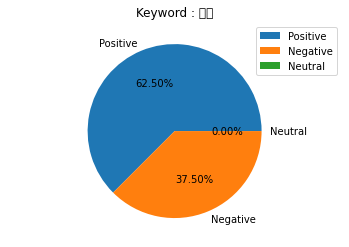

In [73]:

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_path = "/Users/yongheon/Desktop/code/template/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

key = "한강"

size = [numofpos, numofneg, numofneu]

label = ['Positive','Negative','Neutral']

plt.axis('equal')
plt.pie(x=size, labels=label, autopct='%.2f%%')

plt.title("Keyword : " + key)
plt.legend()
plt.show()